In [445]:
# Importing LOTS of stuff 
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, mean_squared_error, classification_report 
import random 
from random import sample

# to solve problems that I am encounterinbg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt #plotting for visualization purposes of story telling 
import numpy as np

#from tqdm import tqdm

import datetime
import gc
import seaborn as sns
sns.set_palette(sns.color_palette('hls', 7))

from statistics import mean
from collections import Counter
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb

from scipy import linalg as la
import networkx as nx
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pickle 
import time

from numpy import array
from numpy import argmax
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
import tensorflow as tf

# Step 0 - read in data and libraries for process 

for a full data description from kaggle, visit this webstie: https://www.kaggle.com/competitions/mens-march-mania-2022/data

The only thing i created by hand is Power the power seeding dictionary. The selection comitte does this, selects teams seeds the tournament. The top overal seed is obviously 1, the second 1 seed, on the opposite side of the bracket is 2, on the same side of the bracket is the third overall and then the fourth overall 1 seed is on the same side as the 1st overall seed. This means that the 5th overall seed is the "best" 2 seed and get the "wrost" 1 seed. and then the process is cyclic, rotating around the tournament from 1 to 64. This is the variable in question I use to generate the outcome variable: Did the higher seed win? 

In [331]:
#what year are we running the analysis for? 
year_ = 2023

In [698]:
#import lots of data 
# teams that could make the tournament all D1 teams 
teams_df = pd.read_csv("../data/MTeams.csv")

#detailed game by game of tournament games from 2003 onward 
tourney_deets = pd.read_csv("../data/MNCAATourneyDetailedResults.csv")

#regular season games from 2003 onwards 
reg_deets = pd.read_csv("../data/MRegularSeasonDetailedResults.csv")

#winner and loser of tournament games since 1985 
tourney_compact_deets =  pd.read_csv("../data/MNCAATourneyCompactResults.csv")

#historical tournament seeds 
tourney_seeds = pd.read_csv("../data/MNCAATourneySeeds.csv")

#conference tournament games detailed results 
conf_tour = pd.read_csv("../data/MConferenceTourneyGames.csv")

#what conferences had who in what year 
conf = pd.read_csv("../data/MTeamConferences.csv")

#hand made varialbe used to create target 
power_seeds = pd.read_csv("../data/PowerSeeds.csv")

compact = pd.read_csv('../data/MNCAATourneyCompactResults.csv')

# Step 1 Data Prep / build dictionaries for features 

The goal here is to use among other things regular season values for each team for each season as features for the model. We will create a multitude of different dictionaries with seasons and teams as keys and things like average 3's made, average turnovers, number of wins etc as values. This will be the general approach we take to model feature creation 

In [333]:
def get_conf_affiliation():
    '''
    Parameters: None
    output: regular season detailed results with the winning 
    and losing team conference afiiliation denoted 
    
    prepping a data frame for getting conference affiliation 
    by season by year here below
    
    '''
    
    step1 = pd.merge(left = reg_deets, right = conf_tour, on = ['Season', "WTeamID"]) 
    
    step1 = step1.drop(columns = ['DayNum_y', 'LTeamID_y'])
    step1 = step1.rename(columns = {'DayNum_x':'DayNum',
                                   'ConfAbbrev':"WTeam_Conf", 
                                   "LTeamID_x":"LTeamID"})
    
    step2 = pd.merge(left = step1, right = conf_tour, on = ['Season', "LTeamID"]) 
    step2 = step2.drop(columns = ['DayNum_y', 'WTeamID_y'])
    step2 = step2.rename(columns = {'DayNum_x':'DayNum','ConfAbbrev':"LTeam_Conf",
                                   'WTeamID_x':'WTeamID'})
    
    return step2

In [334]:
reg_deets2 = get_conf_affiliation()

In [335]:
def get_winning_dict(df, column):
    '''
    building a dictionary for the averages by season by team for when they 
    were the winning team: 
    
    Note - it is possible for a team to go winless, we will need to 
    figure out how to deal with that should we have an undefeated regular season--
    although these teams will not play in march and it seams very unlikely that 
    they don't get a single win, it is possible lol 
    
    '''
    
    features = ['WScore', 'LScore', 'WFGM', 'WFGA', 'WFGM3','WFGA3', 'WFTM', 'WFTA', 'WOR',
                'WTO',
            'WDR', 'WAst', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', ]
    

    

    w = df.groupby(by=[column])
    w1 = pd.DataFrame(w)
    teams = {}
    
    for i in tqdm(range(len(w1))):
        #print(i)
        ws = w1[1][i].groupby("Season")
        ws = pd.DataFrame(ws)
        #print(ws['Season'])
        seasons = {}
        for j in range(len(ws)):
            season = ws[0][j]
            #print(season)
            
            vals = dict(ws[1][j][features].sum(axis = 0))
            vals.update({'season_wins': len(ws[1][j])})
            #vals.update({'conf':list(set(ws[1][j]['WTeam_Conf']))[0]})
            #print(v_dict)
            seasons.update({ws[0][j]:  vals})
        
        teams.update({w1[0][i]:seasons})
    return teams
        
        
        


In [336]:
w_feats = get_winning_dict(reg_deets, "WTeamID")

100%|█████████████████████████████████████████| 368/368 [00:06<00:00, 55.07it/s]


In [337]:
def get_losing_dict(df, column):
    
    '''
    building a dictionary for the averages by season by team for when they 
    were the losing team: 
    
    Note - it is possible for a team to go undefeated, we will need to 
    figure out how to deal with that should we have an undefeated regular season
    
    
    '''
    
    
    features =['WScore', 'LScore', 'WFGM', 'WFGA', 'WFGM3','WFGA3', 'WFTM', 'WFTA', 'WOR',
                'WTO',
            'WDR', 'WAst', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', ]
    
    
    rename = ['LScore', 'WScore', 'LFGM', 'LFGA', 'LFGM3','LFGA3', 'LFTM', 'LFTA', 'LOR',
                'LTO',
            'LDR', 'LAst', 'LStl', 'LBlk', 'LPF', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3',
       'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', ]
    
        
    w = df.groupby(by=[column])
    w1 = pd.DataFrame(w)
    teams = {}
    
    for i in tqdm(range(len(w1))):
        #print(i)
        ws = w1[1][i].groupby("Season")
        ws = pd.DataFrame(ws)
        seasons = {}
        for j in range(len(ws)):
            season = ws[0][j]
            data = ws[1][j][features]
            data.columns = rename
            #vals = dict(data.sum(axis = 0)/len(data))
            vals = dict(data.sum(axis = 0))
            vals.update({'season_losses': len(ws[1][j])})

            seasons.update({ws[0][j]:  vals})
        
        teams.update({w1[0][i]:seasons})
    return teams

In [338]:
l_feats = get_losing_dict(reg_deets, "LTeamID")

100%|█████████████████████████████████████████| 368/368 [00:08<00:00, 44.88it/s]


#### Offensive Efficiency

Calculate the number of total number of possessions for your team using the formula: field goals attempted - offensive rebounds + turnovers + (0.4 x free throws attempted) = total number of possessions for the season. This works because a possession can end only in one of three ways: an attempted field goal, a turnover or a free throw, with an offensive rebound negating additional field goal attempts.

Divide the team's total points scored for the season by the possessions you calculated in Step 1. For example, 938 total points scored divided by 998 total possessions gives your team 0.94 points scored per possession. Numbers above 1.0 are generally considered good.

Convert the offensive PPP number to an efficiency rating by simply multipling by 100. So 0.94 points scored per possession becomes an offensive efficiency rating of 94.

#### Defensive Efficiency

Use the formula field goals attempted - offensive rebounds + turnovers + (0.4 x free throws attempted) = total number of possessions for the season to calculate total team possessions.

Divide the total number of points allowed by your team by the possession total you calculated in Step 1. For example, 1009 total points allowed divided by 998 total possessions gives your team 1.01 points allowed per possession. The opposite is true for defensive PPP: Above 1.0 is bad; below 1.0 is considered good.

Convert defensive points per possession to a defensive efficiency rating by multiplying by 100. So 1.01 points allowed per possession becomes a defensive efficiency rating of 101.



In [339]:
def combine2(w_dict, l_dict):
    '''
    Parameters: winnign dictioanry, losing dictionary 
    
    combining the dictioanries for games won and games lost 
    for the regular season for teams. we will then combine them 
    and get averages for each statistical category and compute 
    things like offensive and defensive efficiency. 
    
    -- NOTE: if we use one of the efficiency metrics, we will not
    be able to use the features that are inputs to that column. 
    because as given, the efficiency is simply a linear combination
    of other features, this will make our matrix non-invertable as our 
    columns will not be independent, so we will have to choose to either 
    keep all of the features seperate or combine and drop some 
    
    '''
    
    
    total = {}
    first = reg_deets.WTeamID.min()
    last = reg_deets.WTeamID.max()+1
    
    features = ['WScore', 'LScore', 'WFGM', 'WFGA', 'WFGM3','WFGA3', 'WFTM', 'WFTA', 'WOR',
                'WTO',
            'WDR', 'WAst', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',]
    
    #for each team from the frist teamID to the last one 
    for i in tqdm(range(first, last+1)):
    #for i in range(first, last+1):
        #print(i)
            
        season = {}
        f_season = 2003 #pd.DataFrame(w_dict[1102]).T.index.min()
        l_season = year_ #pd.DataFrame(w_dict[1102]).T.index.max()+1
        w_l = {}
        for j in range(f_season, l_season+1):
            #print(j)
            try:
                w_df = pd.DataFrame(w_dict[i]).T
                l_df = pd.DataFrame(l_dict[i]).T

                w_df_r = w_df.reset_index()
                l_df_r = l_df.reset_index()



                temp  = pd.concat([w_df_r[w_df_r['index'] == j],l_df_r[l_df_r['index'] == j]])
                temp = temp.fillna(0)

                games = np.sum(temp['season_losses'])+np.sum(temp['season_wins'])

                #temp[features].sum(axis = 0)/games
                season_avg = dict(temp[features].sum(axis = 0)/games)

                w_l.update({'num_loss': np.sum(temp['season_losses'])})
                w_l.update({'num_wins': np.sum(temp['season_wins'])})

                season_avg = season_avg|w_l


                new_key = ['Score', 'Op_score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'TO', 
               'DR', 'Ast', 'Stl', 'Blk', 'PF', 'Op_FGM', 'Op_FGA', 'Op_FGM3', 'Op_FGA3', 
               'Op_FTM', 'Op_FTA', 'Op_OR', 'Op_DR', 'Op_Ast', 'Op_TO', 'Op_Stl', 
               'Op_Blk', 'Op_PF', 'num_loss', 'num_wins', 'conf']

                vals = list(season_avg.values())
                #print(vals)
                new = dict(zip(new_key, vals))
                off_eff = (new['FGA'] - new['OR']+new['Op_TO']+(0.47*new['FTA']))/(new['Score'])*100
                new.update({'off_eff':off_eff})

                def_eff = (new['Op_FGA'] - new['Op_OR']+new['TO']+(0.47*new['Op_FTA']))/(new['Op_score'])*100
                new.update({'def_eff':def_eff})

                equalizer = (new['FGM3']/new['FGA3'])*100
                new.update({'three_perc':equalizer})

                d_equal = (new['Op_FGM3']/new['Op_FGA3'])*100
                new.update({'d_three_perc':d_equal})

                #print(vals)
                #season.update({j:  season_avg})
                season.update({j:  new})



            except:
                #print(i)
                pass
    
        total.update({i:season})
    return total 

In [340]:
total_dict = combine2(w_feats, l_feats)

100%|█████████████████████████████████████████| 378/378 [00:51<00:00,  7.36it/s]


In [341]:
def get_conf_dict(df):
    
    '''
    Many of the tournament titles are played on "Selection Sunday"
    the day the tournament is seeded.  others are played throughout
    "Championship Week". We will need to find a way to group by 
    conference and select the winner on the last day a game was played 
    for a particular conference 

    '''
    
    conf_champ = conf_tour.groupby(["Season", "ConfAbbrev"])["DayNum"].max() 
    
    cdf = pd.DataFrame(conf_champ).reset_index()
    cdf2 = pd.merge(left = cdf, right = conf_tour, on = ['Season', 'ConfAbbrev', 'DayNum'])
    cdf2 = cdf2.drop(columns = ['LTeamID'])
    
    teams = {}
    cdf2 = pd.DataFrame(cdf2.groupby('Season'))
    for i in tqdm(range(len(cdf2))):
        #print(i)
        season = cdf2[1][i]
        year = cdf2[0][i]
        champs = dict(zip(cdf2[1][i]['WTeamID'],cdf2[1][i]['ConfAbbrev']))
        teams.update({year: champs})

    return teams, cdf2
        

In [342]:
# conf_champ = conf_tour.groupby(["Season", "ConfAbbrev"])["DayNum"].max() 
# cdf = pd.DataFrame(conf_champ).reset_index()
# cdf

In [343]:
conf_champs, cdf2 = get_conf_dict(conf_tour)


100%|████████████████████████████████████████| 23/23 [00:00<00:00, 10044.67it/s]


In [344]:
def get_conf_affiliation_dict(df):
    '''
    Parameters: Regular deets 2 which has been merged with the 
    conference tournament data to get the conference afiiliatoin 
    by season by team
    As teams can  move conferences from year to year, it is unclear 
    if the marginal change affects teams, but we wanted to gather the 
    confernece affect and then group them into power, mid major and 
    low major levels to be done later 
    
    
    '''
    reg_deets2
    t1 = pd.DataFrame(df.groupby("Season"))
    cf = {}
    for i in range(len(t1)):
        
        d1 = dict(zip(t1[1][i]['WTeamID'], t1[1][i]['WTeam_Conf']))
        d2 = dict(zip(t1[1][i]['LTeamID'], t1[1][i]['LTeam_Conf']))
        d3 =d1|d2
        cf.update({t1[0][i]:d3})
    
        
    return cf
    



In [345]:
conf_affil = get_conf_affiliation_dict(reg_deets2)

In [346]:
def create_power_seeds_dict(df):
    
    #first add team id to TeamNamein power seeds 
    
    teams2 = teams_df[['TeamID', 'TeamName']]
    
    df2 = pd.merge(left = df, right = teams2, on = 'TeamName') 
    
    df2.to_csv('../data/power_test.csv')
    ps1 = pd.DataFrame(df2.groupby(by = "Season"))
    empty = {}

    for i in range(len(ps1)):
        empty.update({ps1[0][i]: dict(zip(ps1[1][i]['TeamID'], ps1[1][i]['PowerSeed ']))})


    return empty

In [347]:
psd  = create_power_seeds_dict(power_seeds)

In [348]:
def get_power_seeds_tourney(df):
    ''' takes in tourney_deets and gets L team and w team power seeds
    
    TIP: 134, 135 are play in days 
    '''
    
    
    df = df[df['DayNum']  >= 137]
    df = df.reset_index()
    df = df.drop(columns =['index'])
    
    lteam = []
    wteam = []
    for i in tqdm(range(len(df))):
        #print(i)
        try: 
            lteam.append(psd[df['Season'][i]][df['LTeamID'][i]])
            wteam.append(psd[df['Season'][i]][df['WTeamID'][i]])
            #pass
        except:  
            print(df['Season'][i])
            print(i)
            print(df['LTeamID'][i])
            print(" ")
            #wteam.append("error")
            #lteam.append('error')
            #pass
    df['lteam_seed'] = lteam
    df['wteam_seed'] = wteam
    
    df = df.reset_index()
    df = df.drop(columns = ['index'])
    return df 
    
    

In [349]:
tour2 = get_power_seeds_tourney(tourney_deets)

100%|██████████████████████████████████████| 908/908 [00:00<00:00, 48259.26it/s]


In [350]:
def prep_data(df):
    df = df.reset_index()
    ''' 
    takes in tourney_deets df and 
    renames columns based on seeding of low and high seeds
    instead of winning and losing teams, this way our 
    model will not just memorize the order of columns and that 
    will tell the computer who won. And the games we have haven't 
    happened yet so like it doesnt even make sense to run that way lol 
    
    
    ''' 
    
    fav = {'Season':'Season', 'DayNum':'DayNum',
           
           'WTeamID':'HSTeamID', 
           'LTeamID':'LSTeamID', 'WLoc':'WLoc', 'NumOT':'NumOT', 
       
       'WFGM':'HSFGM', 'WFGA':'HSFGA', 'WFGM3':'HSFGM3', 
       'WFGA3':'HSFGA3', 'WFTM':'HSFTM', 'WFTA':'HSFTA', 
       'WOR':'HSOR', 'WDR':'HSDR', 'WAst':'HSAst', 
       'WTO':'HSTO', 'WStl':'HSStl', 'WBlk':'HSBlk', 
       'WPF':'HSPF', "WScore":"HS_Score", 
       
       'LFGM':'LSFGM', 'LFGA':'LSFGA', 'LFGM3':'LSFGM3', 
       'LFGA3':'LSFGA3', 'LFTM':'LSFTM', 'LFTA':'LSFTA', 
       'LOR':'LSOR', 'LDR':'LSDR', 'LAst':'LSAst', 
       'LStl':'LSStl', 'LBlk':'LSBlk', 'LPF':'LSPF', 
        'LTO':'LSTO', "LScore":"LS_Score", 
       
       
       
       'lteam_seed':'ls_seed', 'wteam_seed':'ws_seed'}
    
    up = {'Season':'Season', 'DayNum':'DayNum', 'WTeamID':'LSTeamID', 
       'LTeamID':'HSTeamID', 'WLoc':'WLoc', 'NumOT':'NumOT', 
      
       'WFGM':'LSFGM', 'WFGA':'LSFGA', 'WFGM3':'LSFGM3', 
       'WFGA3':'LSFGA3', 'WFTM':'LSFTM', 'WFTA':'LSFTA', 
       'WOR':'LSOR', 'WDR':'LSDR', 'WAst':'LSAst', 
       'WTO':'LSTO', 'WStl':'LSStl', 'WBlk':'LSBlk', 
       'WPF':'LSPF', "WScore":"LS_Score", 
       
       'LFGM':'HSFGM', 'LFGA':'HSFGA', 'LFGM3':'HSFGM3', 
       'LFGA3':'HSFGA3', 'LFTM':'HSFTM', 'LFTA':'HSFTA', 
       'LOR':'HSOR', 'LDR':'HSDR', 'LAst':'HSAst', 
       'LStl':'HSStl', 'LBlk':'HSBlk', 'LPF':'HSPF',
       'LTO':'HSTO', "LScore":"HS_Score", 
       
       'lteam_seed':'ls_seed', 'wteam_seed':'ws_seed'}
    
    cols = list(fav.values())
    empty = pd.DataFrame(columns = cols)
    
    for i in range(len(df)):
  
        if df['wteam_seed'][i] < df['lteam_seed'][i]:
            #then the favorite won, apply favorite dictionary 
            
            row = df.iloc[[i]]
            row = row.rename(columns = fav)
            empty = pd.concat([empty, row])
        else:
            #apply upset_dictioanry 
            row = df.iloc[[i]]
            row = row.rename(columns = up)
            empty = pd.concat([empty, row])
            
    
    empty = empty.drop(columns = ['index'])
    return empty 
            

In [351]:
tour3 = prep_data(tour2)

In [352]:
#
def power_seed_2(df):
    '''
    up until this pointwe have been using winning vs losing team id's 
    we now are transitioning into lower vs higher seed id. 
    '''
    
    high = []
    low = []
    for i in tqdm(range(len(df))):
        low.append(psd[df['Season'][i]][df['LSTeamID'][i]])
        high.append(psd[df['Season'][i]][df['HSTeamID'][i]])
            #pass
    df['LS_power_seed'] = low
    df['HS_power_seed'] = high
    
    return df 
    

In [353]:
tour3 = power_seed_2(tour3)

100%|██████████████████████████████████████| 908/908 [00:00<00:00, 44990.29it/s]


In [354]:
def get_historical_tourney_perc(df):
    ''' so im at this problem where I cant really use team ID as a dummy column 
    if I want to do a supervized learning technique, the problem being that 
    I would have a massive amount of columns, which would then make inverting 
    it very difficult, I would get a massive number of empty columns, so my data
    would get very sparce very quickly. 
    
    the reason I wanted to use team id would be for the program to have some sort of 
    way to recognize teams that do well across the tournament, Duke, Kentucky, and 
    teams of that nature come to mind. 
    
    Going to build a dictionary with historical win percentages in the tournament. 
    
    we will start from 1985, and go until 2003, and that will be the win percentage for 
    teams going into the 2003 tournament. Then we will have each year from 2003 onwards 
    will be its own year, and will be updated according to the wins and losses of the previous 
    tournament.
    
    this way we do not bias the results by including games that have already happened 
    for historical tournaments. 
    ''' 
    
    # first read in the compact results for the NCAA tournament going back to 1985 
    
    keys = list(range(2003, year_+1))
    #print(keys)
    t_perc = {}
    for i in range(len(keys)):
        #initialize dict 
        season = {}
        #find historical seasons 
        c_tour = df[df['Season'] < keys[i]]
        
        year = keys[i]
        
        wins = c_tour['WTeamID'].value_counts().reset_index()
        losses = c_tour['LTeamID'].value_counts().reset_index()
        
        w_l = pd.merge(left = wins, right = losses, on = 'index')
        w_l['total_games'] = w_l['WTeamID']+w_l['LTeamID']
        
        w_l['win_perc'] = w_l['WTeamID']/w_l['total_games']
        
        w_l['Season'] = year
        year_dict = dict(zip(w_l['index'], w_l['win_perc']))
        
        t_perc.update({year:year_dict})
        
        
    return t_perc      

In [355]:
tw = get_historical_tourney_perc(compact)

In [356]:
#create page rank data 
def make_page_data(df):
    """
    Parameters: takes in regular season compact details, 
    
    we want to calculate page rank: 
    
    Page rank is a google algorithm which is a network theory 
    result basically giving you the degree centrality for the 
    different nodes in the network. 
    
    here our nodes are teams, and the edges are if they played. 
    we want to know which teams beat which teams who beat which 
    teams, there by we can get some sort of degree centrality for 
    the team that beat the most powerful teams... 
    
    we need to get the yearly winners and loosers for the page rank
    structure we have from a homework assignment i did back in like 
    2018. So we get the by year regular season data, store that in 
    individual sheets which will then be fed into our page rank 
    algorithm to give us a by year by team page rank value
    
    """
    
    for i in tqdm(range(2003, year_+1)):
        season = df[df['Season'] == i]
        
        data = season[['WTeamID', "LTeamID"]]
        data = data.rename(columns = {"WTeamID":'Winner', 'LTeamID':'Loser'})
        data.to_csv('../data/page_rank_data/'+str(i)+"_page_data.csv", index = False)

In [357]:
make_page_data(reg_deets)

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 57.87it/s]


In [358]:
# Problems 1-2
# Shout out to Dr Evans for making me do this homework lol 

class DiGraph:
    """A class for representing directed graphs via their adjacency matrices.

    Attributes:
        (fill this out after completing DiGraph.__init__().)
    """
    # Problem 1
    def __init__(self, A, labels=None):
        """Modify A so that there are no sinks in the corresponding graph,
        then calculate Ahat. Save Ahat and the labels as attributes.

        Parameters:
            A ((n,n) ndarray): the adjacency matrix of a directed graph.
                A[i,j] is the weight of the edge from node j to node i.
            labels (list(str)): labels for the n nodes in the graph.
                If None, defaults to [0, 1, ..., n-1].
        """
        for i in range(len(A)):
            if(np.allclose(A[:,i],np.zeros(len(A[0])))):
                #remove sink
                A[:,i] = 1
        #create ahat
        self.Ahat =  A / A.sum(axis=0)
        #get length of A
        self.n = len(A)
        #if no labels
        if labels == None:
            #Set standard
            self.labels = np.arange(0,len(A))
        else:
            #otherwise use labels
            self.labels = labels
            #throw an error if it dosn't match
        if len(A) != len(self.labels):
            raise ValueError("Number of labels is not equal to the number of nodes")


    # Problem 2
    def linsolve(self, epsilon=0.85):
        """Compute the PageRank vector using the linear system method.

        Parameters:
            epsilon (float): the damping factor, between 0 and 1.

        Returns:
            dict(str -> float): A dictionary mapping labels to PageRank values.
        """
        #find values
        p = la.solve(np.identity(self.n)-epsilon*self.Ahat,(1-epsilon)*np.ones(self.n)/self.n)
        #make a dictionary
        dict = {self.labels[i]:p[i] for i in range(self.n)}
        return dict

    # Problem 2
    def eigensolve(self, epsilon=0.85):
        """Compute the PageRank vector using the eigenvalue method.
        Normalize the resulting eigenvector so its entries sum to 1.

        Parameters:
            epsilon (float): the damping factor, between 0 and 1.

        Return:
            dict(str -> float): A dictionary mapping labels to PageRank values.
        """
        #make B
        B = epsilon*self.Ahat+(1-epsilon)/self.n*np.ones((self.n,self.n))
        #get eig stuff
        eigvals, eigvects = la.eig(B)
        #get the eig vector for the largest value
        p = eigvects[:,0].real
        #normalize it
        p = p/p.sum()
        #make a dictionary
        D = {self.labels[i]:p[i] for i in range(self.n)}
        #return the dictionary
        return D

    # Problem 2
    def itersolve(self, epsilon=0.85, maxiter=100, tol=1e-12):
        """Compute the PageRank vector using the iterative method.

        Parameters:
            epsilon (float): the damping factor, between 0 and 1.
            maxiter (int): the maximum number of iterations to compute.
            tol (float): the convergence tolerance.

        Return:
            dict(str -> float): A dictionary mapping labels to PageRank values.
        """
        t = 0
        #set p
        p = [1/self.n for n in range(self.n)]
        #while loop
        while t < maxiter:
            t += 1
            #get the next p
            pt = epsilon*self.Ahat@p + (1 - epsilon)*np.ones(self.n)/self.n
            #stop if it meets the stopping condition
            if(la.norm(pt - p, ord=1) < tol):
                break
            #otherwise reset
            p = pt
        #create the dictionary
        D = {self.labels[i]:pt[i] for i in range(self.n)}
        #return the dicitonary
        return D

# Problem 3
def get_ranks(d):
    """Construct a sorted list of labels based on the PageRank vector.

    Parameters:
        d (dict(str -> float)): a dictionary mapping labels to PageRank values.

    Returns:
        (list) the keys of d, sorted by PageRank value from greatest to least.
    """
    #get the keys
    keys = np.array(list(d.keys()))
    #get the values
    values = list(d.values())
    #create a mask
    mask = np.array(np.argsort(values)[::-1])
    #return the stuff
    return list(keys[mask])

# Problem 5
def rank_ncaa_teams(filename, epsilon=0.85):
    """Read the specified file and construct a graph where node j points to
    node i with weight w if team j was defeated by team i in w games. Use the
    DiGraph class and its itersolve() method to compute the PageRank values of
    the teams, then rank them with get_ranks().

    Each line of the file has the format
        A,B
    meaning team A defeated team B.

    Parameters:
        filename (str): the name of the data file to read.
        epsilon (float): the damping factor, between 0 and 1.

    Returns:
        (list(str)): The ranked list of team names.
    """
    labels = []
    with open(filename,'r') as infile:
        content = infile.read().strip()
    #print(content)
    labels = sorted(set(content.replace('\n',',').split(',')))
    labels.remove("Loser")
    labels.remove("Winner")
    #init dictionary
    Dict = {team: i for i, team in enumerate(labels)}
    #init adjacency matrix
    A = np.zeros((len(labels), len(labels)))
    #get the information from the lines
    for line in content.split('\n')[1:]:
        teams = line.split(',')
        row = Dict[teams[0]]
        column = Dict[teams[1]]
        A[row][column] += 1
    D = DiGraph(A, labels=labels)
    #get the page rank
    PageRank_ = D.itersolve(epsilon = epsilon)
    #return the stuff
    #print(PageRank_)
    return PageRank_, get_ranks(PageRank_)




In [359]:
def get_page_rank():
    '''
    we take the page rank algorithm from above 
    which takes in the page rank data that we have saved 
    previously. 
    
    it will then return a dictionary of seasons 
    which will have a dicitonary of teams and their 
    degree centrality (page rank), which we will then 
    use as a feature for our algorithm later on 
    
    '''
    
    page_data = {}
    teams_rank = {}
    path = '../data/page_rank_data/'
    for i in range(2003, year_+1):
        full_path = path+str(i)+"_page_data.csv"
        #year_data = pd.read_csv(full_path)
        
        year_page, ranked = rank_ncaa_teams(full_path)
        
        page_data.update({i:year_page})
        teams_rank.update({i:ranked})
        
    return page_data, teams_rank
            

In [360]:
page_rank, teams_rank = get_page_rank()

In [361]:
def get_round(df):
    '''
    takes in tournament data, assigns a categorical 
    variable based on DayNum for the round 
    
    DayNum=136 or 137 (Thu/Fri) - Round 1, to bring the tournament field from 64 teams to 32 teams
    DayNum=138 or 139 (Sat/Sun) - Round 2, to bring the tournament field from 32 teams to 16 teams
    DayNum=143 or 144 (Thu/Fri) - Round 3, otherwise known as "Sweet Sixteen", to bring the tournament field from 16 teams to 8 teams
    DayNum=145 or 146 (Sat/Sun) - Round 4, otherwise known as "Elite Eight" or "regional finals", to bring the tournament field from 8 teams to 4 teams
    DayNum=152 (Sat) - Round 5, otherwise known as "Final Four" or "national semifinals", to bring the tournament field from 4 teams to 2 teams
    DayNum=154 (Mon) - Round 6, otherwise known as "national final" or "national championship", to bring the tournament field from 2 teams to 1 champion team
    '''
    
    df['first_round'] = df['DayNum'].apply(lambda x: 1 if x in [136, 137] else 0)
    df['second_round'] = df['DayNum'].apply(lambda x: 1 if x in [138, 139] else 0)
    df['sweet_16'] = df['DayNum'].apply(lambda x: 1 if x in [143, 144] else 0)
    df['elite_8'] = df['DayNum'].apply(lambda x: 1 if x in [145, 146] else 0)
    df['final_four'] = df['DayNum'].apply(lambda x: 1 if x == 152 else 0)
    df['championship'] = df['DayNum'].apply(lambda x: 1 if x == 154 else 0)
    
    return df 

In [362]:
tour4 = get_round(tour3)

In [363]:
def get_reg_avgs2(df):
    """
    Parameters: Tournament details that has gone through the 
    cleaning and prepping phases highlighted above 
    
    ADDITIONALLY: Although not a direct input, but another parameter is the total_dict 
    that we have build to have the regular season averages by team
    by season, that will be used to fill the different features, 
    change those from the actual "in game" values to regular season 
    average values, and then we will add some more features here and 
    a few later on. 
    
    Creating the features that we want for our modeling df --> 
    ready go! 
    
    """  
    df['HS_avg_score'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Score'], axis = 1)
    df['HS_avg_against'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_score'], axis = 1)
    
    df['LS_avg_score'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Score'], axis = 1)
    df['LS_avg_against'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_score'], axis = 1)
    
    
    df['HS_wins'] =  df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['num_wins'], axis = 1)
    df['HS_loss'] =  df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['num_loss'], axis = 1)
    
    df['LS_wins'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['num_wins'], axis = 1)
    df['LS_loss'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['num_loss'], axis = 1)
    
    df['HS_op_FGM'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_FGM'], axis = 1)
    df['HS_op_FGA'] =df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_FGA'], axis = 1)
    df['HS_op_FMG3'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_FGM3'], axis = 1)
    df['HS_op_FGA3'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_FGA3'], axis = 1)
    df['HS_op_OR'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_OR'], axis = 1)
    df['HS_op_DR'] =  df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_DR'], axis = 1)
    df['HS_op_To'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_TO'], axis = 1)
    
    df['LS_op_FGM'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_FGM'], axis = 1)
    df['LS_op_FGA'] =df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_FGA'], axis = 1)
    df['LS_op_FMG3'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_FGM3'], axis = 1)
    df['LS_op_FGA3'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_FGA3'], axis = 1)
    df['LS_op_OR'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_OR'], axis = 1)
    df['LS_op_DR'] =  df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_DR'], axis = 1)
    df['LS_op_To'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_TO'], axis = 1)
    
    
    df['HSFGM'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['FGM'], axis = 1)
    df['HSFGA'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['FGA'], axis = 1)
    df['HSFGM3'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['FGM3'], axis = 1)
    df['HSFGA3'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['FGA3'], axis = 1)
    df['HSFTM'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['FTM'], axis = 1)
    df['HSFTA'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['FTA'], axis = 1)
    df['HSOR'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['OR'], axis = 1)
    df['HSDR'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['DR'], axis = 1)
    df['HSAst'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Ast'], axis = 1)
    df['HSStl'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Stl'], axis = 1)
    df['HSBlk'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Blk'], axis = 1)
    df['HSPF'] = df.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['PF'], axis = 1)
    
    
    df['LSFGM'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['FGM'], axis = 1)
    df['LSFGA'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['FGA'], axis = 1)
    df['LSFGM3'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['FGM3'], axis = 1)
    df['LSFGA3'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['FGA3'], axis = 1)
    df['LSFTM'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['FTM'], axis = 1)
    df['LSFTA'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['FTA'], axis = 1)
    df['LSFTA'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['OR'], axis = 1)
    df['LSDR'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['DR'], axis = 1)
    df['LSAst'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Ast'], axis = 1)
    df['LSStl'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Stl'], axis = 1)
    df['LSBlk'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Blk'], axis = 1)
    df['LSPF'] = df.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['PF'], axis = 1)
    

    #drop columns we dont need 
    df = df.drop(columns = ['DayNum', 'WLoc', 'NumOT', 'ls_seed', 'ws_seed'])   
    return df      

In [364]:
tour5 = get_reg_avgs2(tour4)

In [365]:
tour5.to_csv('testd_for_noah.csv')

In [366]:
def get_conf_data(df):
    '''
    Parameters: takes in data frame from previous function with features almost 
    ready for trainign, 
    
    uses conf_champ dictionary and conf_affil dictionaries to get conference afiliation 
    and if the teams in question were conference champions. 
    
    NOTE: the ivy league only started playing a conference tournament in 2017
    so if not found insert ivy lol 
    '''
    #https://torchcollegerecruiting.com/z_a3_high_mid_low_majors/1641907452726x394612841469246460
    # high vs medium vs low major conferences 

    power_conf = ["acc", 'sec', "big_ten", 
                  "big_twelve", "pac_ten", "pac_twelve"]

    mid_major = ['cusa', 'aac', 'mwc', 'sun_belt', 'ivy', 
                 'mac', 'big_sky', 'meac' ,'southland', 
                 'summit', 'wac', 'wcc',]

    low_major = ['aec', 'a_ten', 'big_south', 'caa', 
                 'nec', 'patriot', 'southern', 'swac', 
                 'mvc', 'a_sun', 'ovc', 'horizon', 
                 'maac', 'swac']    
    
    
    hs_conf= []
    ls_conf = []
    
    hs_conf_champ = []
    ls_conf_champ = []
    for i in tqdm(range(len(df))):
        try:
            hs_conf.append(conf_affil[df['Season'][i]][df['HSTeamID'][i]])

        except:
            hs_conf.append('ivy')

        try:
            ls_conf.append(conf_affil[df['Season'][i]][df['LSTeamID'][i]]) 
        except:
            ls_conf.append('ivy')
        
        
        if df['HSTeamID'][i] in list(conf_champs[df['Season'][i]].keys()):
            hs_conf_champ.append(1)
        else:
            hs_conf_champ.append(0)
        
        if df['LSTeamID'][i] in list(conf_champs[df['Season'][i]].keys()):
            ls_conf_champ.append(1)
        else:
            ls_conf_champ.append(0)
        
        
    
    df['HS_Conf'] = hs_conf
    df['LS_Conf'] = ls_conf
    
    df['HS_power_conf']= df['HS_Conf'].apply(lambda x: 1 if x in power_conf else 0)
    df['HS_mid_conf']= df['HS_Conf'].apply(lambda x: 1 if x in mid_major else 0)
    df['HS_low_conf'] = df['HS_Conf'].apply(lambda x: 1 if x in low_major else 0)
    
    df['LS_power_conf']= df['LS_Conf'].apply(lambda x: 1 if x in power_conf else 0)
    df['LS_mid_conf']= df['LS_Conf'].apply(lambda x: 1 if x in mid_major else 0)
    df['LS_low_conf'] = df['LS_Conf'].apply(lambda x: 1 if x in low_major else 0)    

    df['HS_conf_champ'] = hs_conf_champ
    df['LS_conf_champ'] = ls_conf_champ
    
    
    df = df.drop(columns = ['HS_Conf', 'LS_Conf',])
    return df 

In [367]:
tour6 = get_conf_data(tour5)

100%|██████████████████████████████████████| 908/908 [00:00<00:00, 18636.70it/s]


In [368]:
def apply_page_rank(df):
    '''
    Parameters: tournament DF in the preperation phase for modeling, 
    ADDITIONALLY: page_rank dictionary
    
    Having completed the page rank steps above, we have a page rank dictionary
    "page_rank", which has the by season by team values for the different teams, 
    we will use this to populate page rank for low and high seeds 
    
    '''
    #df['HS_page_rank'] = np.zeros(len(df))
    #df['LS_page_rank'] = np.zeros(len(df))
    
        #print(i)
    df['HS_page_rank'] = df.apply(lambda x: page_rank[x['Season']][str(x['HSTeamID'])], axis = 1)
    df['LS_page_rank'] = df.apply(lambda x: page_rank[x['Season']][str(x['LSTeamID'])], axis = 1)
    return df     
    

In [369]:
tour7 = apply_page_rank(tour6)

In [370]:
def get_hist_wins(df):
    '''
    Parameters: tournament DF in the preperation phase for modeling, 
    ADDITIONALLY: tw (tournament wins) dictionary
    
    having discussed this above, we probably cannot use teamID's as 
    features simply because those will be constantly changing throughout the rounds 
    and years of the tournament, makign it difficult to have consistent features if 
    we trim down / out teams that have been elemenated, but also the dimmensionality 
    will be enormous and be very sparce, so instead we will use historical tournament 
    winning percentage to try and capture some of that "recognize me I've won in the 
    tournament a lot" vibe we might be able to get from team_id 
    
    '''
    df['HS_historical_tournament_win%'] = np.zeros(len(df))
    df['LS_historical_tournament_win%'] = np.zeros(len(df))
    
    
    for i in tqdm(range(len(df))):
        try:
            df['HS_historical_tournament_win%'][i] = tw[df['Season'][i]][df['HSTeamID'][i]]
            df['LS_historical_tournament_win%'][i] = tw[df['Season'][i]][df['LSTeamID'][i]]
        except:
            df['LS_historical_tournament_win%'][i] = 0
        
    return df 
                                                                
                                                    
                                                                  
        

In [371]:
tour8 = get_hist_wins(tour7)

100%|█████████████████████████████████████████| 908/908 [00:51<00:00, 17.49it/s]


In [372]:
def get_target(df):
    '''
    Parameters: DF in prep stage for modeling
    
    with the feature building steps finally complete, 
    our last feature is for us to create our target variabe 
    did the higher seed win or lose? 
    
    '''
    
    df['target'] = tour4.apply(lambda x: 1 if x['HS_Score'] > x['LS_Score'] else 0, axis = 1)
    
    return df 
    
    

In [373]:
tour9 = get_target(tour8)

In [374]:
tour9['target'].value_counts()

1    626
0    282
Name: target, dtype: int64

<AxesSubplot:>

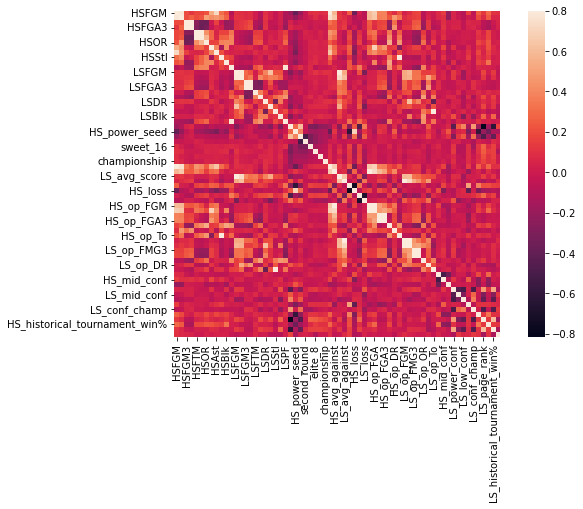

In [375]:
corr_mat = tour9.corr()
f, ax = plt.subplots(figsize = (10, 6))
sns.heatmap(corr_mat,vmax=.8,square=True)

# Training and validation phase 

In [376]:
seasons = list(range(2003, year_))

random.seed(7)
train_seasons = random.sample(seasons, 15)
print("train seasons:", train_seasons)
val_seasons = list(set(seasons)-set(train_seasons))
print("val seasons:", val_seasons)
#get rid of 2020 in val season - no tournament that year 

train seasons: [2013, 2007, 2015, 2004, 2005, 2016, 2011, 2019, 2008, 2012, 2003, 2017, 2006, 2022, 2009]
val seasons: [2018, 2020, 2021, 2010, 2014]


In [377]:
def make_train_val(df):
    
    df['train'] = df['Season'].apply(lambda x: 1 if x in train_seasons else 0)
    df['validate'] = df['Season'].apply(lambda x: 1 if x in val_seasons else 0)
    
    train = df[df['train'] == 1]
    val = df[df['validate']==1]
    
    val = val.drop(columns = ['validate', 'train', "Season", "HSTeamID","LSTeamID",'LS_Score', "HS_Score", ])
    train = train.drop(columns = ['train','validate', "Season","HSTeamID","LSTeamID",'LS_Score', "HS_Score", ])
    
    return val, train

In [378]:
val, train = make_train_val(tour9)

In [498]:
def train_predict(t_df, v_df):
    t_df = t_df.astype(float)
    v_df = v_df.astype(float)
    
    X_train = t_df.drop(columns = ['target'])
    y_train = t_df['target']
    X_val = v_df.drop(columns =['target'])
    y_val = v_df['target']
    
#     #splitting into train_test_split

    xclass = xgb.XGBClassifier()
    
    parameters = {
        'learning_rate':  np.arange(.01, 1, .01), 
        'max_depth': np.arange(5, 50, 3), #
        'subsample': np.arange(.3, .7, .1),
        'colsample_bytree': np.arange(.1, 1, .1),
        'n_estimators' :np.arange(50, 1200, 50), 
        #'objective': ['f1'],  
        }
 
    gs = RandomizedSearchCV(xclass, parameters, cv = 5)
    #gs = GridSearchCV(xclass, parameters, cv = 5)
    gs.fit(X_train, y_train)

    #save trained model in pickle file
    timestr = time.strftime("%Y%m%d-%H%M")
    
    with open('../pickled_out/'+timestr+'_xgb_out.pkl', 'wb') as file:
        pickle.dump(gs, file)
        
        
        
    boost_preds = gs.predict(X_val)
    return boost_preds, y_val, gs

In [499]:
bp,y_a, xgc = train_predict(train, val)

In [500]:
print(classification_report(y_a, bp))

              precision    recall  f1-score   support

         0.0       0.62      0.37      0.46        68
         1.0       0.74      0.89      0.81       135

    accuracy                           0.71       203
   macro avg       0.68      0.63      0.63       203
weighted avg       0.70      0.71      0.69       203



In [501]:
bp

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0])

In [502]:
bp-np.array(y_a)

array([ 0.,  1.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
        1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  1.,  0.,  1.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,
       -1.,  0.,  0.,  0.,  1., -1.,  1.,  0.,  0.,  0., -1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0

In [503]:
print("this is the percentage of time we are picking the favorite to win:", sum(y_a)/len(bp))

this is the percentage of time we are picking the favorite to win: 0.6650246305418719


In [869]:
xgc.best_params_

{'subsample': 0.4,
 'n_estimators': 850,
 'max_depth': 35,
 'learning_rate': 0.09,
 'colsample_bytree': 0.5}

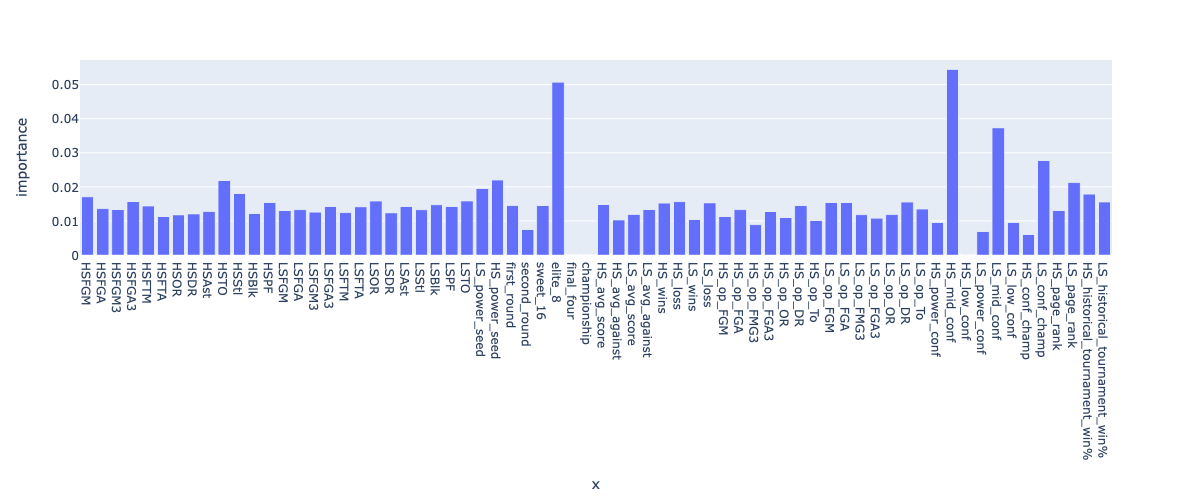

In [881]:
feat_imp = xgc.best_estimator_.feature_importances_
feat_names2 = xgc.feature_names_in_
import plotly.express as px


fig = px.bar(x=feat_names2, y=feat_imp,
             labels={'y':'importance'}, height=500)

fig.write_html("../viz/feat_imp.html")           
fig.show()

In [488]:
# from sklearn.metrics import confusion_matrix
# def plot_confusion_matrix(y_true, y_pred):
#     cm = confusion_matrix(y_true, y_pred)
#     f, ax = plt.subplots(figsize=(8, 6))
#     sns.heatmap(cm, annot=True)
#     plt.title('Confusion Matrix', fontsize=15)
#     plt.ylabel('True label', fontsize=12)
#     plt.xlabel('Predicted label', fontsize=12)
#     plt.xticks([0, 1],
#            ['Upset(0)','No Upset (1)'])
#     plt.yticks([0, 1],
#            ['Upset(0)','No Upset (1)'], rotation = 0)
    
    
# plot_confusion_matrix(y_test, gs.predict(test))
# plt.title("Random Forest With Seeding", fontsize = 15)
# plt.show()
# #THIS IS THE MATRIX OF OUR RANDOM SAMPLE THAT USES SEEDING

# Deep learning model

In [388]:
def binary_encoding(outcome_col):

    labels = []
    for i in outcome_col:
        if i == 1:
            labels.append([1,0])
        else:
            labels.append([0,1])
    return np.array(labels)

In [389]:
def split(df, outcome_col):
    # Split dataset in 60% train, 20% test and 20% validation
    #train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

    train_x = df.drop(columns = [outcome_col])
    train_y = df[outcome_col]
    
    trainy = binary_encoding(train_y)
    
    #test
    

    return train_x, trainy

hidden_nodes = int((1/100) * (len(tour9)))+1
print(f"The number of hidden nodes is {hidden_nodes}.")

The number of hidden nodes is 10.


In [390]:
print("Prepping deep learning data")
d_data_x, d_data_y  = split(train,'target')

Prepping deep learning data


In [391]:
output_labels = 2
def build(train_x, train_y,):
   # Build the model
    print('Build model...')
    
    model = Sequential()
    print(np.array(train_x))
    #model.add(LSTM(hidden_nodes, return_sequences=False, input_shape=(np.array(train_x), np.array(train_x))))
    model.add(Dropout(0.2))
    model.add(Dense(units=output_labels))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    batch_size=25
    
    model.fit(train_x.astype(float), train_y, batch_size=batch_size, epochs=2500)
 
    return model 

In [392]:
#model_multi = build(d_data_x, d_data_y,)

# Build Test Data 

With training data complete, and with the total_dict dictionary holding the values for testing for 2023, we need to build the 2023 infrastructure to be able to test 

In [699]:
### building a list of tuples for the first round match ups 
first_round = [ (1, 64), 
                (2, 63), 
                (3, 62), 
                (4, 61), 
                (5, 57), 
                (6, 58), 
                (7, 59),
                (8, 60), 
                (9, 53), 
                (10,54), 
                (11,55), 
                (12,56), 
                (13,49), 
                (14,50), 
                (15,51), 
                (16,52), 
                (17,45), 
                (18,46), 
                (19,47), 
                (20,48),
                (21,41), 
                (22,42), 
                (23,43), 
                (24,44), 
                (25,37),
                (26,38), 
                (27,39), 
                (28,40),
                (29,33),
                (30,34),
                (31,35),
                (32,36),]

In [700]:
def build_rounds(df, match_ups, tourney_round):
    '''
    Building the test data set from the total_dictionary columns to mirror 
    our testing / validation data set 

    '''
    zero_data = np.zeros(shape=(len(match_ups),len(list(df.columns))))
    testd  = pd.DataFrame(data = zero_data, columns = list(df.columns))
    
    testd['Season'] = year_
    #print(len(testd))
    
    year = psd[year_]
    
    seed_team = dict([(value, key) for key, value in psd[year_].items()])
    
    for i in range(len(testd)):

        testd['HS_power_seed'][i] = match_ups[i][0]
        testd['LS_power_seed'][i] = match_ups[i][1]
        
        testd['HSTeamID'][i] = seed_team[testd['HS_power_seed'][i]]
        testd['LSTeamID'][i] = seed_team[testd['LS_power_seed'][i]]

        
        
    testd['HSFGM'] = testd.apply(lambda x: total_dict[x['HSTeamID']][year_]['FGM'], axis = 1)
    testd['HSFGA'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['FGA'], axis = 1)
    testd['HSFGM3'] = testd.apply(lambda x: total_dict[x['HSTeamID']][year_]['FGM3'], axis = 1)
    testd['HSFGA3'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['FGA3'], axis = 1)
    testd['HSFTM'] = testd.apply(lambda x: total_dict[x['HSTeamID']][year_]['FTM'], axis = 1)
    testd['HSFTA'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['FTA'], axis = 1)
    testd['HSOR'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['OR'], axis = 1)
    testd['HSDR'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['DR'], axis = 1)
    testd['HSAst'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Ast'], axis = 1)
    testd['HSTO'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['TO'], axis = 1)
    testd['HSStl'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Stl'], axis = 1)
    testd['HSBlk'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Blk'], axis = 1)   
    testd['HSPF'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['PF'], axis = 1)
    
 
    
    testd['LSFGM'] = testd.apply(lambda x: total_dict[x['LSTeamID']][year_]['FGM'], axis = 1)
    testd['LSFGA'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['FGA'], axis = 1)
    testd['LSFGM3'] = testd.apply(lambda x: total_dict[x['LSTeamID']][year_]['FGM3'], axis = 1)
    testd['LSFGA3'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['FGA3'], axis = 1)
    testd['LSFTM'] = testd.apply(lambda x: total_dict[x['LSTeamID']][year_]['FTM'], axis = 1)
    testd['LSFTA'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['FTA'], axis = 1)
    testd['LSOR'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['OR'], axis = 1)
    testd['LSDR'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['DR'], axis = 1)
    testd['LSAst'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Ast'], axis = 1)
    testd['LSTO'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['TO'], axis = 1)
    testd['LSStl'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Stl'], axis = 1)
    testd['LSBlk'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Blk'], axis = 1)   
    testd['LSPF'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['PF'], axis = 1)

    
    #psd[df['Season'][i]][df['LSTeamID'][i]]
    testd['LS_power_seed'] = testd.apply(lambda x: psd[year_][x['LSTeamID']], axis = 1)
    testd['HS_power_seed'] = testd.apply(lambda x: psd[year_][x['HSTeamID']], axis = 1)
    
    if tourney_round == 'first':
        testd['first_round'] = 1
        testd['second_round'] = np.zeros(len(testd))
        testd['sweet_16'] = np.zeros(len(testd))
        testd['elite_8'] = np.zeros(len(testd))
        testd['final_four'] = np.zeros(len(testd))
        testd['championship'] = np.zeros(len(testd))
        
    if tourney_round == 'second':
        testd['first_round'] = np.zeros(len(testd))
        testd['second_round'] = 1
        testd['sweet_16'] = np.zeros(len(testd))
        testd['elite_8'] = np.zeros(len(testd))
        testd['final_four'] = np.zeros(len(testd))
        testd['championship'] = np.zeros(len(testd))
        
    if tourney_round == 'third':
        testd['first_round'] = np.zeros(len(testd))
        testd['second_round'] = np.zeros(len(testd))
        testd['sweet_16'] = 1
        testd['elite_8'] = np.zeros(len(testd))
        testd['final_four'] = np.zeros(len(testd))
        testd['championship'] = np.zeros(len(testd))
        
    if tourney_round == 'fourth':
        testd['first_round'] = np.zeros(len(testd))
        testd['second_round'] = np.zeros(len(testd))
        testd['sweet_16'] = np.zeros(len(testd))
        testd['elite_8'] = 1
        testd['final_four'] = np.zeros(len(testd))
        testd['championship'] = np.zeros(len(testd)) 
                                     
    if tourney_round == 'fifth':
        testd['first_round'] = np.zeros(len(testd))
        testd['second_round'] = np.zeros(len(testd))
        testd['sweet_16'] = np.zeros(len(testd))
        testd['elite_8'] = np.zeros(len(testd))
        testd['final_four'] = 1
        testd['championship'] = np.zeros(len(testd)) 
    
    if tourney_round == 'sixth':
        testd['first_round'] = np.zeros(len(testd))
        testd['second_round'] = np.zeros(len(testd))
        testd['sweet_16'] = np.zeros(len(testd))
        testd['elite_8'] = np.zeros(len(testd))
        testd['final_four'] = 1
        testd['championship'] = np.zeros(len(testd)) 
            
    
    testd['HS_avg_score'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Score'], axis = 1)
    testd['HS_avg_against'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_score'], axis = 1)
    testd['LS_avg_score'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Score'], axis = 1)
    testd['LS_avg_against'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_score'], axis = 1)

    
    testd['HS_wins'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['num_wins'], axis = 1)
    testd['HS_loss'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['num_loss'], axis = 1)
    testd['LS_wins'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['num_wins'], axis = 1)
    testd['LS_loss'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['num_loss'], axis = 1)
    
    
    testd['HS_op_FGM'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_FGM'], axis = 1)
    testd['HS_op_FGA'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_FGA'], axis = 1)
    testd['HS_op_FMG3'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_FGM3'], axis = 1)
    testd['HS_op_FGA3'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_FGA3'], axis = 1)
    testd['HS_op_OR'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_OR'], axis = 1)
    testd['HS_op_DR'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_DR'], axis = 1)
    testd['HS_op_To'] = testd.apply(lambda x: total_dict[x['HSTeamID']][x['Season']]['Op_TO'], axis = 1)

    
    
    testd['LS_op_FGM'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_FGM'], axis = 1)
    testd['LS_op_FGA'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_FGA'], axis = 1)
    testd['LS_op_FMG3'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_FGM3'], axis = 1)
    testd['LS_op_FGA3'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_FGA3'], axis = 1)
    testd['LS_op_OR'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_OR'], axis = 1)
    testd['LS_op_DR'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_DR'], axis = 1)
    testd['LS_op_To'] = testd.apply(lambda x: total_dict[x['LSTeamID']][x['Season']]['Op_TO'], axis = 1)
                                                                                        
    

    
    
    testd['ls_conf'] = testd['LSTeamID'].apply(lambda x:  conf_affil[2023][x])
    testd['hs_conf'] = testd['HSTeamID'].apply(lambda x:  conf_affil[2023][x])
    
    power_conf = ["acc", 'sec', "big_ten", 
                  "big_twelve", "pac_ten", "pac_twelve"]

    mid_major = ['cusa', 'aac', 'mwc', 'sun_belt', 'ivy', 
                 'mac', 'big_sky', 'meac' ,'southland', 
                 'summit', 'wac', 'wcc',]

    low_major = ['aec', 'a_ten', 'big_south', 'caa', 
                 'nec', 'patriot', 'southern', 'swac', 
                 'mvc', 'a_sun', 'ovc', 'horizon', 
                 'maac', 'swac']    
    
    
    testd['HS_power_conf'] = testd['hs_conf'].apply(lambda x: 1 if x in power_conf else 0)
    testd['HS_mid_conf'] = testd['hs_conf'].apply(lambda x: 1 if x in mid_major else 0)
    testd['HS_low_conf'] = testd['hs_conf'].apply(lambda x: 1 if x in low_major else 0)
    
    testd['LS_power_conf'] = testd['ls_conf'].apply(lambda x: 1 if x in power_conf else 0)
    testd['LS_mid_conf'] = testd['ls_conf'].apply(lambda x: 1 if x in mid_major else 0)
    testd['LS_low_conf'] = testd['ls_conf'].apply(lambda x: 1 if x in low_major else 0)
    

    testd['HS_conf_champ'] = testd['HSTeamID'].apply(lambda x: 1 if x in list(conf_champs[2023].keys()) else 0)
    testd['LS_conf_champ'] = testd['LSTeamID'].apply(lambda x: 1 if x in list(conf_champs[2023].keys()) else 0)

    
    testd = testd.drop(columns = ['ls_conf', 'hs_conf'])
    
    testd['HS_page_rank'] = testd.apply(lambda x: page_rank[x['Season']][str(int(x['HSTeamID']))], axis = 1)
    testd['LS_page_rank'] = testd.apply(lambda x: page_rank[x['Season']][str(int(x['LSTeamID']))], axis = 1)
    
    testd['HS_historical_tournament_win%'] = testd.apply(lambda x: tw[x['Season']][x['HSTeamID']] if x['HSTeamID'] in tw[x['Season']].keys() else 0 , axis = 1)
    testd['LS_historical_tournament_win%'] = testd.apply(lambda x: tw[x['Season']][x['LSTeamID']] if x['LSTeamID'] in tw[x['Season']].keys() else 0, axis = 1)
    
   
    return testd
    
    
    
    

In [829]:
def build_second_round(result):
    '''
    building a function that takes in the result of the first round and 
    delivers a list of tuples containing the power seeds of the following
    round, we will then iteritevly build the rounds as the 
    tournament progresses 
    
    '''

    second = []
   
    if result[0] ==1:
        if result[31] == 1:
            second.append((first_round[0][0], first_round[31][0]))
         
        else:
            second.append((first_round[0][0], first_round[31][1]))
            print("inside first couble else ")
    else:
        if result[31] == 1:
            second.append((first_round[0][1], first_round[31][0]))
        else:
            second.append((first_round[0][1], first_round[31][1]))
    
    if result[1] ==1:
        if result[30] == 1:
            second.append((first_round[1][0], first_round[30][0]))
        else:
            second.append((first_round[1][0], first_round[30][1]))

    else:
        if result[30] == 1:
            second.append((first_round[1][1], first_round[30][0]))
        else:
            second.append((first_round[1][1], first_round[30][1]))
    
    if result[2] ==1:
        if result[29] == 1:
            second.append((first_round[2][0], first_round[29][0]))
        else:
            second.append((first_round[2][0], first_round[29][1]))

    else:
        if result[29] == 1:
            second.append((first_round[2][1], first_round[29][0]))
        else:
            second.append((first_round[2][1], first_round[29][1]))
    
    if result[3] ==1:
        if result[28] == 1:
            second.append((first_round[3][0], first_round[28][0]))
        else:
            second.append((first_round[3][0], first_round[28][1]))

    else:
        if result[28] == 1:
            second.append((first_round[3][1], first_round[28][0]))
        else:
            second.append((first_round[3][1], first_round[28][1]))
########## 
    if result[4] ==1:
        if result[24] == 1:
            second.append((first_round[4][0], first_round[24][0]))
        else:
            second.append((first_round[4][0], first_round[24][1]))

    else:
        if result[24] == 1:
            second.append((first_round[4][1], first_round[24][0]))
        else:
            second.append((first_round[4][1], first_round[24][1]))
    
    if result[5] ==1:
        if result[25] == 1:
            second.append((first_round[5][0], first_round[25][0]))
        else:
            second.append((first_round[5][0], first_round[25][1]))
    else:
        if result[25] == 1:
            second.append((first_round[5][1], first_round[25][0]))
        else:
            second.append((first_round[5][1], first_round[25][1]))
    
    if result[6] ==1:
        if result[26] == 1:
            second.append((first_round[6][0], first_round[26][0]))
        else:
            second.append((first_round[6][0], first_round[26][1]))

    else:
        if result[26] == 1:
            second.append((first_round[6][1], first_round[26][0]))
        else:
            second.append((first_round[6][1], first_round[26][1]))
    
    if result[7] ==1:
        if result[27] == 1:
            second.append((first_round[7][0], first_round[27][0]))
        else:
            second.append((first_round[7][0], first_round[27][1]))

    else:
        if result[27] == 1:
            second.append((first_round[7][1], first_round[27][0]))
        else:
            second.append((first_round[7][1], first_round[27][1]))
            
    if result[11] ==1:
        if result[23] == 1:
            second.append((first_round[11][0], first_round[23][0]))
        else:
            second.append((first_round[11][0], first_round[23][1]))
    else:
        if result[23] == 1:
            second.append((first_round[11][1], first_round[23][0]))
        else:
            second.append((first_round[11][1], first_round[23][1]))
            
    if result[10] ==1:
        if result[22] == 1:
            second.append((first_round[10][0], first_round[22][0]))
        else:
            second.append((first_round[10][0], first_round[22][1]))
    else:
        if result[22] == 1:
            second.append((first_round[10][1], first_round[22][0]))
        else:
            second.append((first_round[10][1], first_round[22][1]))

            
    if result[9] ==1:
        if result[21] == 1:
            second.append((first_round[9][0], first_round[21][0]))
        else:
            second.append((first_round[9][0], first_round[21][1]))
    else:
        if result[21] == 1:
            second.append((first_round[9][1], first_round[21][0]))
        else:
            second.append((first_round[9][1], first_round[21][1]))       
            
            
    if result[8] ==1:
        if result[20] == 1:
            second.append((first_round[8][0], first_round[20][0]))
        else:
            second.append((first_round[8][0], first_round[20][1]))
    else:
        if result[20] == 1:
            second.append((first_round[8][1], first_round[20][0]))
        else:
            second.append((first_round[8][1], first_round[20][1]))
        
            
######

    if result[12] ==1:
        if result[16] == 1:
            second.append((first_round[12][0], first_round[16][0]))
        else:
            second.append((first_round[12][0], first_round[16][1]))
    else:
        if result[16] == 1:
            second.append((first_round[12][1], first_round[16][0]))
        else:
            second.append((first_round[12][1], first_round[16][1]))
            
    
            
            
    if result[13] ==1:
        if result[17] == 1:
            second.append((first_round[13][0], first_round[17][0]))
        else:
            second.append((first_round[13][0], first_round[17][1]))
    else:
        if result[17] == 1:
            second.append((first_round[13][1], first_round[17][0]))
        else:
            second.append((first_round[13][1], first_round[17][1]))
            
            
            
            
    if result[14] ==1:
        if result[18] == 1:
            second.append((first_round[14][0], first_round[18][0]))
        else:
            second.append((first_round[14][0], first_round[18][1]))
    else:
        if result[18] == 1:
            second.append((first_round[14][1], first_round[18][0]))
        else:
            second.append((first_round[14][1], first_round[18][1]))
            
            
                        
            
    if result[15] ==1:
        if result[19] == 1:
            second.append((first_round[15][0], first_round[19][0]))
        else:
            second.append((first_round[15][0], first_round[19][1]))
    else:
        if result[19] == 1:
            second.append((first_round[15][1], first_round[19][0]))
        else:
            second.append((first_round[15][1], first_round[19][1]))         
            
            
            
    
    return second 


def get_names(matchups):
    pyear = power_seeds[power_seeds['Season'] ==year_]
    
    yd = dict(zip(pyear['PowerSeed '], pyear['TeamName']))
    for i in range(len(matchups)):
        print(yd[matchups[i][0]]+ " v " +yd[matchups[i][1]])
        
def get_next(n_games, prev_round, result):
    current_round = []
    for i in range(0,n_games):
        if result[i] ==1:
            if result[-i-1] == 1:
            
                current_round.append((prev_round[i][0], prev_round[-i-1][0]))
                #print(first_round[-i][0])
            else:
                current_round.append((prev_round[i][0], prev_round[-i-1][1]))

        else:
            if result[-i-1] == 1:
                current_round.append((prev_round[i][1], prev_round[-i-1][0]))
            else:
                current_round.append((prev_round[i][1], prev_round[-i-1][1]))
                
    current_round = list(pd.Series(current_round).apply(lambda x:x if x[0]<x[1] else (x[1], x[0])))
    return current_round

In [862]:
#load in past mod
xgb_model_loaded = pickle.load(open('../pickled_out/20230315-1702_xgb_out.pkl', "rb"))
xgb_model_loaded.best_params_

{'subsample': 0.5,
 'n_estimators': 1050,
 'max_depth': 29,
 'learning_rate': 0.08,
 'colsample_bytree': 0.8}

In [877]:
def full_bracket(df, xgc, loaded_model = False):
    
    if loaded_model == False:
        xgc = xgc
    else:
        xgc = xgb_model_loaded
    
    
    r1 =  build_rounds(df, first_round, 'first')
    r1 = r1[list(train.columns)]
    r1 = r1.drop(columns = 'target')
    
    
    r1_preds = xgc.predict(r1)
    
    
    second_match = build_second_round(r1_preds)
    print("Second Round Matchups: ")
    get_names(second_match)
    print(" ")
    
    r2 = build_rounds(tour9, second_match, 'second')
    r2 = r2[train.columns]
    r2 = r2.drop(columns = ['target'])
    
    r2_preds = xgc.predict(r2)
    
    
    third_match = get_next(8, second_match, r2_preds)
    print("Sweet 16 Matchups: ")
    get_names(third_match)
    print(" ")
    
    r3 = build_rounds(tour9, third_match, 'third')
    r3 = r3[train.columns]
    r3 = r3.drop(columns = ['target'])
    
    r3_preds = xgc.predict(r3)
    
    
    fourth_match = get_next(4, third_match, r3_preds)
    print("Elite 8 Matchups: ") 
    get_names(fourth_match)
    print(" ")
    
    r4 = build_rounds(tour9, fourth_match, 'fourth')
    r4 = r4[train.columns]
    r4 = r4.drop(columns = ['target'])
    
    r4_preds = xgc.predict(r4)
    
    
    fifth_match = get_next(2, fourth_match, r4_preds)
    print("Final Four Matchups: ")
    get_names(fifth_match)
    print(" ")
    
    r5 = build_rounds(tour9, fifth_match, 'fifth')
    r5 = r5[train.columns]
    r5 = r5.drop(columns = ['target'])
    
    r5_preds = xgc.predict(r5)
    
    
    sixth_match = get_next(1, fifth_match, r5_preds)
    print("Championship Matchups: ")
    get_names(sixth_match)
    print(" ")
    
    r6 = build_rounds(tour9, sixth_match, 'sixth')
    r6 = r6[train.columns]
    r6 = r6.drop(columns = ['target'])

    r6_preds = xgc.predict(r6)
    
    print(r6_preds)
    


In [879]:
full_bracket(tour9, xgc, loaded_model = False)

Second Round Matchups: 
Alabama v Maryland
Houston v Iowa
Kansas v Illinois
Purdue v FL Atlantic
Marquette v Michigan St
UCLA v Northwestern
Texas v Penn St
Arizona v Missouri
Baylor v Creighton
Xavier v Pittsburgh
Gonzaga v Arizona St
Kansas St v Kentucky
Tennessee v Duke
Connecticut v St Mary's CA
Indiana v Miami FL
Virginia v San Diego St
 
Sweet 16 Matchups: 
Virginia v Maryland
Houston v Indiana
Kansas v Connecticut
Purdue v Duke
Marquette v Kentucky
UCLA v Gonzaga
Texas v Xavier
Arizona v Baylor
 
Elite 8 Matchups: 
Arizona v Virginia
Houston v Texas
Kansas v UCLA
Purdue v Marquette
 
Final Four Matchups: 
Purdue v Arizona
Houston v UCLA
 
Championship Matchups: 
Houston v Purdue
 
[1]
